<img style="float: left;" src="images/logo.png" width=200>

# Does Mobility Make or Break Friendships? - Data Analysis
---
## Part 0: Imports and loading


In [483]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pycountry
import reverse_geocode
import pycountry_convert as pc

import requests

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity

import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import functions as fn

In [484]:
# Data folder and dataset location
DATA_FOLDER = 'data/'
FOURSQUARE_FRIENDSHIP_OLD_DATASET = DATA_FOLDER + "dataset_WWW_friendship_old.txt"
FOURSQUARE_FRIENDSHIP_NEW_DATASET = DATA_FOLDER + "dataset_WWW_friendship_new.txt"
PREPROCESSED_FRIENDSHIP_DATASET = DATA_FOLDER + "friendship_df.csv.zip"
PREPROCESSED_CHECKIN_DATASET = DATA_FOLDER + "checkin_df.csv.zip"
PREPROCESSED_VENUE_DATASET = DATA_FOLDER + "venue_df.csv.zip"

# Read datasets and create dataframes
friendship_old_df = pd.read_csv(FOURSQUARE_FRIENDSHIP_OLD_DATASET, sep='\t', header=None)
friendship_new_df = pd.read_csv(FOURSQUARE_FRIENDSHIP_NEW_DATASET, sep='\t', header=None)
friendship_df = pd.read_csv(PREPROCESSED_FRIENDSHIP_DATASET)
checkin_df = pd.read_csv(PREPROCESSED_CHECKIN_DATASET)
venue_df = pd.read_csv(PREPROCESSED_VENUE_DATASET)

In [485]:
# Convert check-in time to datetime format
checkin_df['checkin_time'] = pd.to_datetime(checkin_df['checkin_time'])

# Add columns to friendship networks
friendship_old_df.columns = ['user_id', 'friendship']
friendship_new_df.columns = ['user_id', 'friendship']

In [525]:
venue_df.level_1_category.nunique()

275

---

## Part 1: Introduction

Our data has been cleaned in the 'preprocessing.ipynb' notebook, now it's time for analysis. We have a two snapshot of Foursquare friendships before and after a 22 month period. Our aim is to create an accurate model that will use a user's mobility to predict how many friendships a they will make over this 22 month period.

First, we will use the same technique as the "Friendship and Mobility" paper. This consists of finding a user's home by dividing the world into 25km x 25km cells, calculating which cell has the most check-ins for each user, and calculating the average position of check-ins within this cell.

First we have to merge the venue information and the check-in information dataframes.

In [62]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_0_category','level_1_category'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,country_code
18306712,938573,4e65899b62e13e3bcff72c7e,2013-03-21 13:49:26,34.884960,136.996059,JP
13152133,1117956,4e72e3cb88778d253ae33bed,2012-05-19 19:33:02,56.746783,53.061691,RU
3218676,1076304,4bed413cbac3c9b65dfbfde9,2012-06-06 19:30:04,35.871912,139.926276,JP


Then we discretise the world into 25km x 25km cells.

In [63]:
# Global variable for cell size
CELL = 25

# Create dataframe
discrete_df = merged_df.copy()

# Calculate index and discrete value of latitude
index_lat = ((90 + discrete_df.latitude)/fn.km_to_lat(CELL)).astype(int)
discrete_lat = index_lat*fn.km_to_lat(CELL)-90

# Calculate index and discrete value of longitude
index_lon = ((180 + discrete_df.longitude)/fn.km_to_lon(discrete_lat, CELL)).astype(int)
discrete_lon = index_lon*fn.km_to_lon(discrete_lat, CELL)-180

# Add columns to dataframe
discrete_df['discrete_latitude'] = discrete_lat
discrete_df['discrete_longitude'] = discrete_lon
discrete_df['position_id'] = index_lat.astype(str) + '-' + index_lon.astype(str)

# Visualise dataframe
discrete_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,country_code,discrete_latitude,discrete_longitude,position_id
18370162,1435091,50d9937ce4b0f0bf6049acc9,2013-03-28 19:20:50,41.032215,28.823717,TR,40.851294,28.657986,582-702
757866,366840,4bec5abd2bc1b713e977bf3a,2013-04-21 10:11:14,-30.036294,-51.215644,BR,-30.195113,-51.238263,266-495
6917422,501741,4d0019d5ffcea14345532b91,2013-08-23 16:45:06,-1.422013,-48.456457,BR,-1.641652,-48.645131,393-584


Then we find each user's home cell.

In [64]:
# Group by user and position index and count amount of position indexes
home_cell_df = discrete_df.groupby(['user_id','discrete_latitude','discrete_longitude','position_id'],
                                   as_index = False)['latitude'].count()

# Group by user and select max number of position indexes
home_cell_df = home_cell_df.loc[home_cell_df.groupby('user_id')['latitude'].idxmax()]

# Reformat and rename data 
home_cell_df = home_cell_df.drop(['position_id', 'latitude'], axis=1)
home_cell_df.columns = ['user_id','home_cell_latitude','home_cell_longitude']
    
# Visualise dataframe
home_cell_df.sample(3)

,user_id,home_cell_latitude,home_cell_longitude
1077053,1465563,13.646815,100.410852
1208138,1887327,40.851294,28.657986
295042,235256,40.176802,-74.066917


Then we find each user's home.

In [65]:
# Merge checkins dataframe with home cell dataframe
home_df = pd.merge(merged_df, home_cell_df, on='user_id')

# Keep checkins within home cell
home_df = home_df[(home_df['latitude'] >= home_df['home_cell_latitude']) & \
                  (home_df['latitude'] < home_df['home_cell_latitude'] + fn.km_to_lat(CELL))]

home_df = home_df[(home_df['longitude'] >= home_df['home_cell_longitude']) & \
                  (home_df['longitude'] < home_df['home_cell_longitude'] + \
                   fn.km_to_lon(home_df['home_cell_latitude'], CELL))]

# Group by user for mean latitude and longitude
home_df = home_df.groupby('user_id', as_index = False)[['latitude', 'longitude']].mean()

# Rename and Visualize data
home_df.columns = ['user_id', 'home_latitude', 'home_longitude']

# Visualise dataframe
home_df.sample(3)

,user_id,home_latitude,home_longitude
46587,696187,40.997395,29.070006
67469,1118634,41.014826,28.865963
69300,1160535,41.045129,29.014708


To plot this information, we want to know which country a home is in. We have the country codes for venue IDs, but not for home locations. To get this information we need to use some reverse geocoding to get a country from coordinates.

In [80]:
# Get country name and country code
home_df['country_code'] = home_df.apply(lambda x: fn.get_country_code(x['home_latitude'],x['home_longitude']), axis=1)
home_df['country'] = home_df.apply(lambda x: fn.get_country_name(x['home_latitude'],x['home_longitude']), axis=1)

# Count homes on rach country
home_count_df = home_df.groupby(['country', 'country_code']).count().reset_index()

# Format dataframe for plotting
home_count_df = home_count_df.drop(['home_latitude', 'home_longitude'], axis = 1)
home_count_df['display'] = home_count_df['country'] + ': ' + home_count_df['user_id'].astype(str)
home_count_df.columns = ['country', 'country_code', 'number_of_homes', 'display']
home_count_df['continent'] = home_count_df.apply(lambda x: fn.get_continent_name(x['country_code']), axis=1)

# Visualise dataframe
home_count_df.sample(3)

,country,country_code,number_of_homes,display,continent
36,Dominican Republic,DOM,174,Dominican Republic: 174,North America
78,Luxembourg,LUX,3,Luxembourg: 3,Europe
48,Ghana,GHA,44,Ghana: 44,Africa


We can also compute the number of checkins per country.

In [68]:
# Get checkins per country 
checkin_count_df = merged_df.groupby('country_code').count().reset_index()
checkin_count_df = checkin_count_df.drop(['venue_id', 'checkin_time', 'latitude', 'longitude'], axis=1)
checkin_count_df.columns = ['country_code', 'number_of_checkins']
checkin_count_df['country'] = checkin_count_df.apply(lambda x: fn.alpha2_to_name(x['country_code']), axis=1)
checkin_count_df['country_code'] = checkin_count_df.apply(lambda x: fn.alpha2_to_alpha3(x['country_code']), axis=1)
checkin_count_df['display'] = checkin_count_df['country']+': '+checkin_count_df['number_of_checkins'].astype(str)
checkin_count_df = checkin_count_df.dropna()

# Visualise dataframe
checkin_count_df.sample(3)

,country_code,number_of_checkins,country,display
177,RUS,534230,Russian Federation,Russian Federation: 534230
91,HRV,6065,Croatia,Croatia: 6065
76,GUF,118,French Guiana,French Guiana: 118


We can merge thesedataframes in one to plot.

In [73]:
temp_df = pd.merge(home_count_df, checkin_count_df, on=['country_code','country'])
temp_df.sample(3)

,country,country_code,number_of_homes,display_x,continent,number_of_checkins,display_y
82,Maldives,MDV,61,Maldives: 61,Asia,12638,Maldives: 12638
42,Finland,FIN,59,Finland: 59,Europe,11179,Finland: 11179
73,Kyrgyzstan,KGZ,5,Kyrgyzstan: 5,Asia,998,Kyrgyzstan: 998


In [509]:
# Data
cols_dd = ["number_of_homes", "number_of_checkins"]

# we need to add this to select which trace 
# is going to be visible
visible = np.array(cols_dd)

cscale = ['#003f5c','#1e4365','#32466e','#454a76','#574c7d','#684e82','#7a5087',
          '#8d518b','#9f518e','#b25190','#c3528c','#d15782','#dc5d78','#e6656e',
          '#ef6e63','#f57858','#fa824b','#fd8e3c','#ff9a29','#ffa600']

colorbar[0] = dict(title='Number of homes', tickvals = [0, 1, 2, 3, 4], 
                ticktext = ['1', '10', '100', '1000','10000'])

colorbar[1] = dict(title='Number of checkins', tickvals = [0, 1, 2, 3, 4, 5, 6], 
                ticktext = ['1', '100', '100', '1000', '10000', '100000', '1000000'])

# define traces and buttons at once
traces = []
buttons = []
for i, value in enumerate(cols_dd):
    if value == 'number_of_homes':
        title = 'Number of Homes'
        disp = 'display_x'
    elif value == 'number_of_checkins':
        title = 'Number of Checkins'
        disp = 'display_y'
        
    traces.append(go.Choropleth(
        locations=temp_df['country_code'], # Spatial coordinates
        z=np.log10(temp_df[value]), # Data to be color-coded
        hovertemplate = temp_df[disp],
        colorscale = cscale,
        colorbar = colorbar[i],
        colorbar_title=title,
        visible= True if value==cols_dd[0] else False))

    buttons.append(dict(label=title,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"{title}"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))

fig.update_geos(projection_type="natural earth")

# This is in order to get the first title displayed correctly
first_title = 'Number of Homes'
fig.update_layout(title=f"{first_title}",title_x=0.54,title_y=0.89)
fig.show()

We can also display a bar chart showing the number of check-ins homes and for the top 20 countries.

In [517]:
temp1 = home_count_df.sort_values(by=['number_of_homes'], ascending=False)
temp1 = temp1.reset_index(drop=True)
temp1 = temp1.head(20)
temp1 = temp1.sort_values(by=['number_of_homes'])

temp2 = checkin_count_df.sort_values(by=['number_of_checkins'], ascending=False)
temp2 = temp2.reset_index(drop=True)
temp2 = temp2.head(20)
temp2 = temp2.sort_values(by=['number_of_checkins'])


fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing = 0.046)

fig.add_trace(go.Bar(
            x=np.array(temp1.number_of_homes),
            y=np.array(temp1.country_code),
            customdata=np.array(temp1.country),
            orientation='h',
            showlegend=False), 1, 1)

fig.add_trace(go.Bar(
            x=np.array(temp2.number_of_checkins),
            y=np.array(temp2.country_code),
            customdata = np.array(temp2.country),
            orientation='h',
            showlegend=False), 1, 2)

fig.update_layout(title="Home and check-in numbers for top 20 countries",
                  title_x=0.5,
                  title_y=0.89,
                  xaxis_title="Number of homes",
                  xaxis2_title="Number of check-ins",
                  yaxis_title=" ",
                  plot_bgcolor='#F5F5FF',
                  height=600, 
                  width=950)

fig.update_traces(textposition='outside',
                  marker_color=cscale,
                  hovertemplate = 'Number: %{x:f}'+'<br>Country: %{customdata}<extra></extra>')

fig.update_xaxes(autorange='reversed', row=1, col=1)
fig.update_yaxes(side='right', row=1, col=1)

fig.show()

We can plot a nice visualisation of the categories as well. We merge venue information with checkin information and group the number of check-ins by level 0 category to see which categories are the most popular.

In [447]:
# Merge dataframes
merged_df = df_checkins_cleaned.merge(df_venues_cleaned, on='venue_id')

# Group values by level_0_category
merged_df_grouped = merged_df.groupby('level_0_category').size().reset_index(name='number_of_checkins')
merged_df_grouped = merged_df_grouped.sort_values(by='number_of_checkins', ascending = False)

# Visualise dataframe
merged_df_grouped

,level_0_category,number_of_checkins
3,Food,3885074
9,Shop & Service,3120378
10,Travel & Transport,2760016
7,Professional & Other Places,2664898
8,Residence,1856524
6,Outdoors & Recreation,1736333
1,College & University,1513662
0,Arts & Entertainment,929240
4,Nightlife Spot,831598
2,Event,8381


Plot check-ins per level 0 category.

In [520]:
# Plot
data = merged_df_grouped

fig = px.bar(data, x='level_0_category', y='number_of_checkins',
             hover_data=['level_0_category', 'number_of_checkins'], color='number_of_checkins',
             labels={'number_of_checkins':'Number of Checkins', 'level_0_category':'Level 0 Category'}, 
             height=400, width=950)

cscale = ['#003f5c', '#31466d', '#534c7b', '#755086', '#98518d', '#bb5090', '#d6597e', '#e9676b', '#f67a55',
          '#fe8f3b', '#ffa600']

cscale.reverse()

fig.update_traces(marker_color=cscale,
                  hovertemplate = 'Category: %{x}'+'<br>Number of checkins: %{y:f}<extra></extra>')
fig.show()

---
## Part 2: Check-in social scores

We merge the checkin and venue dataframes to get information for each checkin.

In [13]:
# Merge dataframes
checkin_hour_df = pd.merge(checkin_df, venue_df, on='venue_id')
checkin_hour_df = checkin_hour_df.drop(['latitude','longitude','country_code'], axis=1)
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category
18055484,1043184,50505899e4b0473d5f361c11,2013-02-26 16:10:40,Bridge,Outdoors & Recreation,Bridge
17735824,345216,5029481ee4b0c75a16b585e1,2013-01-25 13:48:19,Peruvian Restaurant,Food,Latin American Restaurant
18148685,77354,4c411845a5c5ef3b6c27b06f,2013-08-13 17:46:29,Bus Station,Travel & Transport,Bus Station


We create a new dataframe assigning coefficients to each level 0 category.

In [14]:
categories = checkin_hour_df.level_0_category.unique()
social_score = [1.5, 1.1, 1.3, 1.3, 1, 1.2, 1.1, 1.4, 1.3, 1.5, 1]
category_social_score_df = pd.DataFrame({'level_0_category':categories, 'level_0_coefficient':social_score})
category_social_score_df

,level_0_category,level_0_coefficient
0,Nightlife Spot,1.5
1,Professional & Other Places,1.1
2,College & University,1.3
3,Food,1.3
4,Shop & Service,1.0
5,Travel & Transport,1.2
6,Residence,1.1
7,Outdoors & Recreation,1.4
8,Arts & Entertainment,1.3
9,Event,1.5


We merge this dataframe with the previous one to get the following.

In [15]:
checkin_hour_df = pd.merge(checkin_hour_df, category_social_score_df, on='level_0_category')
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient
18221866,1256708,50a379c5e4b0da0c1e75e77c,2013-05-08 20:06:13,Gym / Fitness Center,Outdoors & Recreation,Athletics & Sports,1.4
9046068,1379277,4b9a82f8f964a52058bc35e3,2013-07-02 14:40:53,Mall,Shop & Service,Shopping Mall,1.0
399143,358275,4e8b1c7c722e2d278e513897,2012-08-14 23:05:27,Bar,Nightlife Spot,Bar,1.5


We floor the check-in time to get the check-in hour.

In [16]:
checkin_hour_df['checkin_hour'] = checkin_hour_df.checkin_time.dt.floor('H').dt.hour
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour
8595667,943334,5053f9b8e4b0359ed539d111,2013-02-17 17:59:53,Pizza Place,Food,Pizza Place,1.3,17
18323193,1353499,4d1a164685fc6dcb07bdc24e,2013-06-07 19:16:09,Yoga Studio,Outdoors & Recreation,Athletics & Sports,1.4,19
4627138,938366,4f7183a7e4b0559c39132579,2012-06-09 14:27:29,College Classroom,College & University,College Classroom,1.3,14


We find the peak hours for each checkin by computing the number of minimum hours that have a total of 40% of checkins.

In [17]:
level_1_category_df = pd.DataFrame({'level_1_category': checkin_hour_df.level_1_category.unique()})
level_1_category_df['peak_hours'] = np.nan
level_1_category_df['peak_hours'] = level_1_category_df['peak_hours'].astype('object')

for index, row in level_1_category_df.iterrows():   
    # Group by checkin hour for each category
    checkin_count_df = checkin_hour_df[checkin_hour_df.level_1_category==
                                       row['level_1_category']].groupby(checkin_hour_df['checkin_hour']).count()

    # Drop column and reset index for easier handling
    checkin_count_df = checkin_count_df.drop('checkin_hour', axis=1)
    checkin_count_df = checkin_count_df.reset_index()

    # Get peak hours
    arr = np.array(checkin_count_df['user_id'])
    n = fn.smallest_subset_size(arr, 0.4*sum(arr))
    peak_hours = list(checkin_count_df.nlargest(n, 'user_id').checkin_hour.sort_values())
    level_1_category_df.at[index, 'peak_hours'] = peak_hours

# Visualise peak hour dataframe
level_1_category_df.sample(3)

,level_1_category,peak_hours
89,Scandinavian Restaurant,"[12, 16, 18, 19, 20]"
90,BBQ Joint,"[12, 18, 19, 20]"
15,Event Space,"[13, 14, 15, 17, 18, 19]"


We merge this dataframe with our previous information.

In [18]:
# Merge information
peak_hour_df = pd.merge(checkin_hour_df, level_1_category_df, on='level_1_category')

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours
10997699,319340,4b59997ff964a520468e28e3,2013-07-12 17:30:25,Bookstore,Shop & Service,Bookstore,1.0,17,"[16, 17, 18, 19]"
16807282,579289,4b9500d8f964a5201c8b34e3,2012-12-10 12:33:56,Gym / Fitness Center,Outdoors & Recreation,Athletics & Sports,1.4,12,"[16, 17, 18, 19, 20]"
15452321,1637333,4f928901e4b0324618bbaca9,2013-05-04 17:39:16,Home (private),Residence,Home (private),1.1,17,"[18, 19, 20, 21, 22, 23]"


We check if each checkin is within the peak hours of its level 1 category.

In [19]:
# Is checkin in peak hours?
peak_hour_df['social_visit'] = peak_hour_df.apply(lambda x: x['checkin_hour'] in x['peak_hours'], axis=1)
peak_hour_df['social_visit'] = peak_hour_df['social_visit'].replace({True: 2, False: 1})

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours,social_visit
3347290,705145,4fa34adfe4b02e6a53caae9c,2012-05-04 10:20:04,Factory,Professional & Other Places,Factory,1.1,10,"[7, 8, 9, 10]",2
16348990,1029868,4f8cdae2e4b05cdaa05b3310,2013-05-18 16:31:19,Residential Building (Apartment / Condo),Residence,Residential Building (Apartment / Condo),1.1,16,"[18, 19, 20, 21, 22, 23]",1
13372271,771254,4b305b8af964a52022f924e3,2012-07-17 08:31:44,Metro Station,Travel & Transport,Metro Station,1.2,8,"[7, 8, 9, 17, 18, 19]",2


We now give each check-in a social score according to the following formula:

$S = (level \; 0 \; coef)*(social \; visit)$

With $(social \; visit)=1$ if the visit is not within peak hours, and $(social \; visit)=2$ if it is.

In [20]:
# Compute social score
peak_hour_df['social_score'] = peak_hour_df['level_0_coefficient']*peak_hour_df['social_visit']

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours,social_visit,social_score
1568913,305366,4b587475f964a520945828e3,2013-01-17 13:31:42,Office,Professional & Other Places,Office,1.1,13,"[8, 9, 10]",1,1.1
3873212,210931,4c554a32b3b09c74d65a44b4,2013-02-19 08:27:11,College Gym,College & University,College Gym,1.3,8,"[16, 17, 18, 19, 20]",1,1.3
1614226,1063418,4c2814d2ed0ac9b6bbcf5faa,2012-12-03 11:15:46,Office,Professional & Other Places,Office,1.1,11,"[8, 9, 10]",1,1.1


From this we create a new dataframe with the social score for each user. The user social score is the mean of all of their check-in social scores.

In [21]:
# Compute user social score
user_social_score_df = pd.DataFrame(peak_hour_df.groupby('user_id')['social_score'].mean())
user_social_score_df = user_social_score_df.reset_index()

# Visualise dataframe
user_social_score_df.sample(3)

,user_id,social_score
63793,1037054,1.503333
39036,561727,1.578871
1433,15196,1.769767


---
## Part 3: Travel score

We want to take a look at the distribution of friends as a function of distance to define a radius that will define whether a user has "travelled" for a check-in. Do do this we use calculate the probability distribution of the distance between a users check-ins and their home.

First we merge all of the venue and check-in information into a single dataframe.

In [22]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_0_category','level_1_category','country_code'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude
11620818,348446,4e85cf3702d58a685e93fac2,2012-05-16 10:11:14,-23.651004,-46.637853
100331,1825729,4b9605aff964a5206dba34e3,2013-05-24 16:08:42,41.010053,29.041086
18374799,1664896,4e018e0bd4c0836163dc1274,2013-03-29 09:57:24,41.080077,29.008385


We then compute the distance between each check-in and the users home.

In [23]:
# Create new dataframe with only checkin locations and id
checkins_dist_df = merged_df.copy().drop('checkin_time', axis=1)

# Modify dataframe by merging it with home locations
checkins_dist_df = pd.merge(checkins_dist_df, home_df, on='user_id')

# Drop unnecessary columns
checkins_dist_df = checkins_dist_df.drop(['country_code','country'], axis=1)

# Create a new column with the distance between the checkin and user's home
checkins_dist_df['distance_from_home'] = fn.geo_to_km(checkins_dist_df['latitude'],
                                                      checkins_dist_df['longitude'], 
                                                      checkins_dist_df['home_latitude'], 
                                                      checkins_dist_df['home_longitude'])

# Remove unnecessary columns
checkins_dist_df = checkins_dist_df.drop(['home_latitude', 'home_longitude'], axis=1)

# visualise dataframe
checkins_dist_df.sample(3)

,user_id,venue_id,latitude,longitude,distance_from_home
17831266,429174,4c221e0434faef3b0e92586d,28.459259,77.072868,14.970789
7868268,19678,4e617618aeb7360314804371,41.380655,2.180762,10016.403512
11516195,411330,4b776766f964a52039982ee3,36.737835,127.157607,91.409467


We remove checkins at home.

In [24]:
checkins_dist_df = checkins_dist_df[checkins_dist_df.distance_from_home != 0]

We plot the distribution.

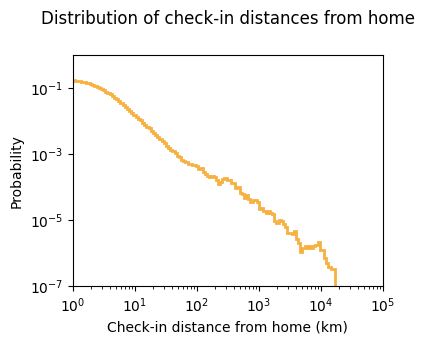

In [25]:
# Change plot style
plt.style.use('default')

# Create linear histogram with linearly spaced bins
_, bins = np.histogram(checkins_dist_df['distance_from_home'], bins=500)

# Create logarithmically spaced bins
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

# Create and plot new histograms with correct bin size
f, ax = plt.subplots(figsize=(4, 3))

n, bins, _ = plt.hist(checkins_dist_df['distance_from_home'], 
                            histtype=u'step', bins=logbins, 
                            density=True, linewidth=2, color='#F6B141')

ax.set(xscale="log", yscale="log")
ax.set_xlim(1,1e5)
ax.set_ylim(1e-7,1)
plt.ylabel('Probability')
plt.xlabel('Check-in distance from home (km)')
_ = plt.title('Distribution of check-in distances from home', y=1.1)

We observe that the distribution follows a power law with a kink in the data at between 70 and 200km from user homes. We Will therefore use the upper value 200km to determine if a user has "traveled" or not for their check-in.

In [26]:
# Get total number of checkins
checkin_count_df = checkins_dist_df.groupby('user_id').count().reset_index()
checkin_count_df = checkin_count_df.drop(['latitude', 'longitude', 'distance_from_home'], axis=1)
checkin_count_df.columns = ['user_id', 'number_of_checkins']

# Get number of "travel" checkins
travel_checkins_dist_df = checkins_dist_df[checkins_dist_df.distance_from_home >= 200]
travel_checkins_dist_df = travel_checkins_dist_df.groupby('user_id').count().reset_index()
travel_checkins_dist_df = travel_checkins_dist_df.drop(['latitude', 'longitude', 'distance_from_home'], axis=1)
travel_checkins_dist_df.columns = ['user_id', 'number_of_travel_checkins_distance']

# Merge dataframes
travel_df = pd.merge(checkin_count_df, travel_checkins_dist_df, on='user_id')

# Fraction of travel checkins (distance)
travel_df['travel_fraction_distance'] = travel_df.number_of_travel_checkins_distance/travel_df.number_of_checkins

# Visualise dataframe
travel_df.sample(3)

,user_id,number_of_checkins,number_of_travel_checkins_distance,travel_fraction_distance
53107,1069521,118,2,0.016949
4666,59320,131,12,0.091603
56037,1154580,104,2,0.019231


We can also use foursquare categories to determine if a user is a traveler or not. Indeed one of the level 0 categories is "Travel & Transport".

In [27]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_1_category','country_code'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,level_0_category
15253118,1722848,4fce3a1ae4b083992e29446f,2014-01-29 14:10:18,-1.952596,30.075520,Nightlife Spot
6864314,310658,4dd31d11d22d4d4d4087ad60,2012-05-16 06:48:49,14.218211,121.038008,College & University
4083592,310361,4b6ac8b5f964a5202be02be3,2012-10-18 19:41:16,-33.414029,-70.600151,Food


In [28]:
# Get "Travel & Transport" category checkins
travel_checkins_category_df = merged_df[merged_df.level_0_category == 'Travel & Transport']
travel_checkins_category_df = travel_checkins_category_df.groupby('user_id').count().reset_index()
travel_checkins_category_df = travel_checkins_category_df.drop(['checkin_time','latitude',
                                                                'longitude','level_0_category'], axis=1)
travel_checkins_category_df.columns = ['user_id', 'number_of_travel_checkins_category']

# Merge with previous dataframe
travel_df = pd.merge(travel_df, travel_checkins_category_df, on='user_id')

# Fraction of travel checkins (category)
travel_df['travel_fraction_category'] = travel_df.number_of_travel_checkins_category/travel_df.number_of_checkins

# Visualise dataframe
travel_df.sample(3)

,user_id,number_of_checkins,number_of_travel_checkins_distance,travel_fraction_distance,number_of_travel_checkins_category,travel_fraction_category
18590,292252,130,19,0.146154,18,0.138462
40529,760324,146,36,0.246575,46,0.315068
9698,132734,321,26,0.080997,4,0.012461


We can plot the mobility of two different type of users differentiated by their travel score. First we create a dataframe with check-in locations and home locations for each user.

In [334]:
# Merge dataframes
home_and_checkins_df = pd.merge(checkin_df, venue_df, on='venue_id')
home_and_checkins_df = home_and_checkins_df.drop(['category','level_0_category',
                                                  'level_1_category','country_code'], axis=1)

# Create new dataframe with only checkin locations and id
home_and_checkins_df = merged_df.copy().drop('checkin_time', axis=1)

# Modify dataframe by merging it with home locations
home_and_checkins_df = pd.merge(home_and_checkins_df, home_df, on='user_id')

# Drop unnecessary columns
home_and_checkins_df = home_and_checkins_df.drop(['country_code','country'], axis=1)

# Visualise
home_and_checkins_df.sample(3)

,user_id,venue_id,latitude,longitude,home_latitude,home_longitude
8054281,14862,4c6a7fe31a6620a1022c668c,-26.835713,-65.211125,-26.836649,-65.204937
7396744,672176,4fc9edd2e4b008fb53431d5a,55.626250,37.668263,55.753230,37.584958
8301774,1860577,4e82c7debe7b92ebc89147b7,2.991377,101.788106,2.992706,101.761886


We can then plot the mobility of different type of users according to their travel scores (distance).

In [527]:
fig = go.Figure()

colors = ['#c3528c', '#c3528c', '#c3528c',
          '#ffa600', '#ffa600', '#ffa600']

users_low = np.array(user_score_df[user_score_df.travel_score_distance<0.3].user_id.sample(3))
users_high = np.array(user_score_df[user_score_df.travel_score_distance>0.6].user_id.sample(3))
users = np.concatenate((users_low, users_high))

for i,u in enumerate(users):
    df = home_and_checkins_df[home_and_checkins_df.user_id == u]
    
    fig.add_trace(go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        hoverinfo = None,
        mode = 'markers',
        marker = dict(
            size = 3,
            color = colors[i],
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.add_trace(go.Scattergeo(
        lon = df.head(1)['home_longitude'],
        lat = df.head(1)['home_latitude'],
        hoverinfo = None,
        mode = 'markers',
        marker = dict(
            size = 13,
            color = colors[i],
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    lons = []
    lats = []
    lons = np.empty(3 * len(df))
    lons[::3] = df['home_longitude']
    lons[1::3] = df['longitude']
    lons[2::3] = None
    lats = np.empty(3 * len(df))
    lats[::3] = df['home_latitude']
    lats[1::3] = df['latitude']
    lats[2::3] = None

    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = lons,
            lat = lats,
            mode = 'lines',
            line = dict(width = 2,color = colors[i]),
            opacity = 0.8
        )
    )

fig.update_layout(
    title={
        'text': 'User mobility for high (orange) and low (purple) travel scores',
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    showlegend = False,
    geo = go.layout.Geo(
        #scope = 'north america',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    height=700,
)

fig.show()

We can clearly see that users with a higher travel score tend to have a lot more check-ins abroad, and much further away than none travelers.

---
## Part 4: User scores

We create a dataframe with the three user scores:
* Social Score
* Travel Score (distance)
* Travel Score (category)

In [298]:
# Create user score dataframe
user_score_df = user_social_score_df.copy()

# Remove unnecessary columns
travel_score_df = travel_df.drop(['number_of_checkins', 
                                  'number_of_travel_checkins_distance', 
                                  'number_of_travel_checkins_category'],axis=1)

# Merge dataframes to get user score dataframe
user_score_df = pd.merge(user_score_df, travel_score_df, on='user_id')

# Rename columns
user_score_df.columns = ['user_id', 'social_score', 'travel_score_distance', 'travel_score_category']

# Visualise dataframe
user_score_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
33468,592246,1.703226,0.122984,0.070565
39901,745588,1.911811,0.251969,0.157480
52618,1077785,1.917647,0.058824,0.023529


We normalise the scores.

In [301]:
# Copy dataframe
user_score_norm_df = user_score_df.copy()

# Normalise scores
user_score_norm_df['social_score'] = (user_score_norm_df.social_score - \
                                      user_score_norm_df.social_score.min()) / \
                                      (user_score_norm_df.social_score.max() - \
                                       user_score_norm_df.social_score.min())

user_score_norm_df['travel_score_distance'] = (user_score_norm_df.travel_score_distance - \
                                               user_score_norm_df.travel_score_distance.min()) / \
                                               (user_score_norm_df.travel_score_distance.max() - \
                                                user_score_norm_df.travel_score_distance.min())

user_score_norm_df['travel_score_category'] = (user_score_norm_df.travel_score_category - \
                                               user_score_norm_df.travel_score_category.min()) / \
                                                (user_score_norm_df.travel_score_category.max() - \
                                                 user_score_norm_df.travel_score_category.min())

user_score_norm_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
47404,930957,0.557731,0.045919,0.080561
28186,479412,0.392500,0.494235,0.228665
39309,730610,0.406005,0.077396,0.239554


In [ ]:
# Normalise the scores 
user_score_norm_df['display_social'] = user_score_norm_df['country'] + ': ' + \
                                          round(user_score_norm_df['social_score'],4).astype(str)

user_score_norm_df['display_travel_distance'] = user_score_norm_df['country'] + ': ' + \
                                                   round(user_score_norm_df['travel_score_distance'],4).astype(str)

user_score_norm_df['display_travel_category'] = user_score_norm_df['country'] + ': ' + \
                                                   round(user_score_country_df['travel_score_category'],4).astype(str)

We merge with the home location dataframe, groupby the country and calculate the mean of each score per country.

In [303]:
# Merge dataframes
user_score_home_df = pd.merge(user_score_norm_df, home_df, on='user_id')
user_score_home_df = user_score_home_df.drop(['home_latitude', 'home_longitude'], axis=1)

# Grouby country
user_score_country_df = user_score_home_df.groupby(['country_code','country']).mean().reset_index()
user_score_country_df.drop('user_id', axis=1)

# New columns for plot display
user_score_country_df['display_social'] = user_score_country_df['country'] + ': ' + \
                                          round(user_score_country_df['social_score'],4).astype(str)
user_score_country_df['display_travel_distance'] = user_score_country_df['country'] + ': ' + \
                                                   round(user_score_country_df['travel_score_distance'],4).astype(str)
user_score_country_df['display_travel_category'] = user_score_country_df['country'] + ': ' + \
                                                   round(user_score_country_df['travel_score_category'],4).astype(str)

# Visualise the dataframe
user_score_country_df.sample(3)

,country_code,country,user_id,social_score,travel_score_distance,travel_score_category,display_social,display_travel_distance,display_travel_category
115,SAU,Saudi Arabia,1.000589e+06,0.399812,0.218580,0.121735,Saudi Arabia: 0.3998,Saudi Arabia: 0.2186,Saudi Arabia: 0.1217
45,FRA,France,7.463984e+05,0.499052,0.213567,0.171448,France: 0.4991,France: 0.2136,France: 0.1714
110,PYF,French Polynesia,9.976900e+05,0.514540,0.102527,0.061045,French Polynesia: 0.5145,French Polynesia: 0.1025,French Polynesia: 0.061


In [333]:
# Data
cols_dd = ["social_score", "travel_score_distance", "travel_score_category"]
# we need to add this to select which trace 
# is going to be visible
visible = np.array(cols_dd)

cscale = ['#003f5c','#1e4365','#32466e','#454a76','#574c7d','#684e82','#7a5087',
          '#8d518b','#9f518e','#b25190','#c3528c','#d15782','#dc5d78','#e6656e',
          '#ef6e63','#f57858','#fa824b','#fd8e3c','#ff9a29','#ffa600']
# define traces and buttons at once
traces = []
buttons = []
for value in cols_dd:
    if value == 'social_score':
        title = 'Mean Social Score by Country'
        b = 'Social Score'
    elif value == 'travel_score_distance':
        title = 'Mean Travel Score (distance) by Country'
        b = 'Travel Score <br>(distance)'
    elif value == 'travel_score_category':
        title = 'Mean Travel Score (category) by Country'
        b = 'Travel Score <br>(category)'
    traces.append(go.Choropleth(
        locations=user_score_country_df['country_code'], # Spatial coordinates
        z=user_score_country_df[value].astype(float), # Data to be color-coded
        colorscale = cscale,
        colorbar_title='Score',
        visible= True if value==cols_dd[0] else False))

    buttons.append(dict(label=b,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"{title}"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))

fig.update_geos(projection_type="natural earth")

fig.update_traces(hovertemplate = 'Score: %{z}<extra></extra>')

# This is in order to get the first title displayed correctly
first_title = 'Mean Social Score by Country'
fig.update_layout(title=f"{first_title}",title_x=0.54,title_y=0.87)
fig.show()

---
## Part 5: Cosine Similarity


In [355]:
# Copy dataframes
df_checkins_cleaned = checkin_df.copy()
df_friendships_cleaned = friendship_df.copy()
df_venues_cleaned = venue_df.copy()

First we want to compute the evolution of a user's friendships: $\frac{n_{friends}(after) - n_{friends}(before)}{n_{friends}(before)}$

In [356]:
# Compute friendship evolution
df_friendships_cleaned['friends_evolution'] = (df_friendships_cleaned['num_friends_after'] - \
                                               df_friendships_cleaned['num_friends_before']) / \
                                                df_friendships_cleaned['num_friends_before']

# Visualise dataframe
df_friendships_cleaned.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,friends_evolution
48735,845263,6,16,10,1.666667
66484,1468684,1,3,2,2.000000
46583,796027,1,5,4,4.000000


We can now merge the checkins dataframe with the venues dataframe, group by the level 1 category and calculate the scaled frequency at which each user visits each venue within a level 1 category. After this we split the data into training (80%) and testing (20%) sets.

In [357]:
# Merge dataframes
df_merged = df_checkins_cleaned.merge(df_venues_cleaned, how='left', on='venue_id')
df_merged = df_merged[df_merged.user_id.isin(df_friendships_cleaned.user_id)]

# Groupby level 1 category
df_final = df_merged.groupby(['user_id', 'level_1_category']).size().reset_index(name='frequency')

# Get checkins in category
nbr_checkins = df_merged.groupby('user_id').size().reset_index(name='number_of_checkins')

# Create scaled frequency dataframe
df_final = df_final.merge(nbr_checkins, on='user_id', how='left')
df_final['adj_frequency'] = df_final['frequency'] / df_final['number_of_checkins'] * 1.0
df_final = df_final.pivot(index='user_id', columns='level_1_category', values='adj_frequency').fillna(0)
df_final.head()

# Split data
train, test = train_test_split(df_final, train_size=0.8)

In [358]:
# Visualise dataframe
df_final.sample(3)

level_1_category,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,...,Video Game Store,Video Store,Vineyard,Volcano,Voting Booth,Water Park,Well,Winery,Wings Joint,Zoo
user_id,,,,,,,,,,,,,,,,,,,,,
571710,0.0,0.0,0.0,0.018182,0.00000,0.0,0.0,0.0,0.009091,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448666,0.0,0.0,0.0,0.007874,0.00000,0.0,0.0,0.0,0.007874,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
241748,0.0,0.0,0.0,0.004525,0.00905,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We want to find 5 users in the training set that are the most similar to a particular user in the testing set according to the check-ins they have made.

In [379]:
# Get scores from cosine similarity
sim_scores = cosine_similarity(test, train)

# Sort similarity scores
sorted_sim = np.argsort(sim_scores, axis=1)
sorted_sim = sorted_sim[:, -6:-1]

We get the 5 similar user's id value.

In [380]:
user_IDs = train.index.values
venue_IDs = list(train.columns.values)

top_n_idx = []
top_n_userIDs = []
top_n_scores = []
top_n_new_friendships = []

for i in range(len(sorted_sim)):
    top_n_idx.append(sorted_sim[i])
    top_n_userIDs.append(user_IDs.take(sorted_sim[i])) #Inefficient
    top_n_scores.append(sim_scores[i].take(sorted_sim[i]))

top_n_idx = np.array(top_n_idx)
top_n_userIDs = np.array(top_n_userIDs)
top_n_scores = np.array(top_n_scores)

We create a datframe with the sorted 5 most similar user's to each individual user.

In [382]:
# Create and format dataframe
orted_df_with_user_ids = pd.DataFrame(top_n_userIDs)
sorted_df_with_user_ids.index = test.index
sorted_df_with_user_ids.columns = ['most_similar', 'second', 'third', 'fourth', 'fifth']

# Visualise dataframe
sorted_df_with_user_ids.sample(3)

,most_similar,second,third,fourth,fifth
user_id,,,,,
535083,794798,46617,1266912,748640,56236
716325,629383,674218,969094,615081,927561
74928,30212,317474,789918,333758,97186


We determine how the number of friends of these users changed over the data collection period.

In [390]:
# Replace user id values by the friendship evolution value.
sorted_new = sorted_df_with_user_ids.copy()

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='most_similar', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['most_similar'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='second',
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['second'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='third', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['third'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='fourth', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['fourth'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='fifth', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['fifth'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new.sample(3)

,most_similar,second,third,fourth,fifth
user_id,,,,,
31667,2.0,0.000000,0.333333,2.0,0.000000
659250,4.0,-0.250000,1.000000,5.0,13.000000
453620,21.0,0.052632,1.000000,0.0,5.666667


We compute the estimated variation of the number of friends of the users in the test set.

In [391]:
# Predict evolution
sorted_new['predicted_friends_evolution'] = ((16*sorted_new['most_similar'] + \
                                              8*sorted_new['second'] + \
                                              4*sorted_new['third'] + \
                                              2*sorted_new['fourth'] + \
                                              1*sorted_new['fifth']) / 31)

# Visualise dataframe
sorted_new.head()

,most_similar,second,third,fourth,fifth,predicted_friends_evolution
user_id,,,,,,
407168,0.000000,3.000,0.000000,0.666667,0.5,0.833333
627336,-0.333333,0.000,-0.666667,0.857143,0.0,-0.202765
687315,-0.166667,2.000,1.000000,2.000000,5.0,0.849462
404468,0.000000,23.000,-0.500000,2.000000,-0.1,5.996774
731096,7.000000,-0.125,0.000000,2.000000,0.0,3.709677


We merge with the friendship dataframe and convert the evolution in to the number of friends gained.

In [392]:
# Merge dataframes
sorted_new = sorted_new.merge(df_friendships_cleaned, on='user_id')

# Compute friend gain
sorted_new['predicted_friends_gained'] = np.round(sorted_new.predicted_friends_evolution * \
                                                  (1+sorted_new.num_friends_before))

# Visualise dataframe
sorted_new.sample(3)

,user_id,most_similar,second,third,fourth,fifth,predicted_friends_evolution,num_friends_before,num_friends_after,num_friends_gained,friends_evolution,predicted_friends_gained
10372,461846,1.000000,0.0,0.000000,0.6,-0.272727,0.546041,15,22,7,0.466667,9.0
9284,315374,0.714286,1.0,0.666667,2.0,1.666667,0.895545,6,7,1,0.166667,6.0
9277,1098407,2.000000,0.0,0.000000,0.0,-0.888889,1.003584,2,2,0,0.000000,3.0


We plot the histogram of residuals.

0.4222503160556258

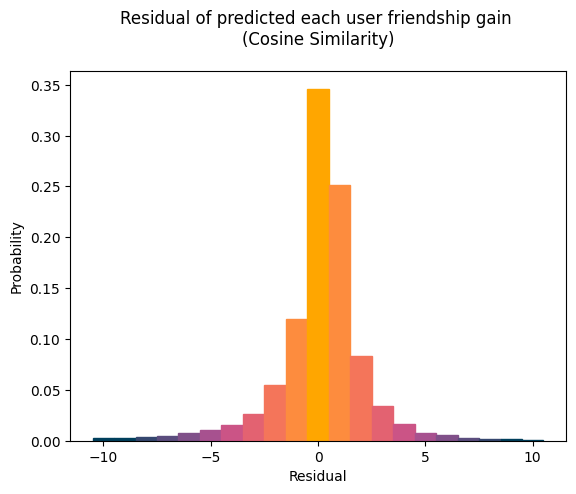

In [550]:
colors = ['#003f5c', '#003f5c', '#35476f', '#5b4d7e', '#805089', 
          '#a7518f', '#cb5486', '#e36271', '#f4755a', '#fd8c3e', 
          '#ffa600', '#fd8c3e', '#f4755a', '#e36271', '#cb5486', 
          '#a7518f', '#805089', '#5b4d7e', '#35476f', '#003f5c', '#003f5c']

residual = sorted_new.predicted_friends_evolution - sorted_new.friends_evolution
N, bins, patches = plt.hist(residual, bins=np.linspace(-10.5, 10.5, 22), density=True)

for i in range(len(patches)):
    patches[i].set_color(colors[i])

plt.title('Residual of predicted each user friendship gain \n(Cosine Similarity)', y=1.05)
plt.xlabel("Residual")
plt.ylabel("Probability")

len(residual[(residual > 1) | (residual < -1)]) / len(residual)

---
## Part 6: Regression models


In [430]:
friendship_df['variation'] = (friendship_df.num_friends_after-friendship_df.num_friends_before)/ \
                                friendship_df.num_friends_before

In [431]:
friendship_df.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,variation
37430,595806,5,4,-1,-0.200000
61111,1209911,1,3,2,2.000000
9587,116078,36,42,6,0.166667


In [432]:
user_score_df['social_score'] = (user_score_df.social_score-user_score_df.social_score.min())/ \
                                (user_score_df.social_score.max()-user_score_df.social_score.min())

user_score_df['travel_score_distance'] = (user_score_df.travel_score_distance-user_score_df.travel_score_distance.min())/ \
                                       (user_score_df.travel_score_distance.max()-user_score_df.travel_score_distance.min())

user_score_df['travel_score_category'] = (user_score_df.travel_score_category-user_score_df.travel_score_category.min())/ \
                                       (user_score_df.travel_score_category.max()-user_score_df.travel_score_category.min())

user_score_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
45669,886008,0.521205,0.166486,0.278368
8581,115340,0.597514,0.028520,0.011787
53714,1108988,0.559653,0.203866,0.086127


In [433]:
merged_df = pd.merge(friendship_df, user_score_df, on='user_id')

merged_df.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,variation,social_score,travel_score_distance,travel_score_category
36459,757926,25,27,2,0.08,0.456737,0.209477,0.216066
27744,524041,1,13,12,12.00,0.528602,0.083805,0.044059
30665,594903,1,1,0,0.00,0.371924,0.551647,0.076900


In [440]:
train_df, test_df = train_test_split(merged_df, train_size=0.8)

features = ['social_score','travel_score_distance','travel_score_category']
features = ['travel_score_distance','travel_score_category']
label = 'variation'

X_train = train_df[features]
y_train = train_df[label]
X_test = test_df[features]
y_test = test_df[label]

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

predicted_variation = lin_reg.predict(X_test)

model_df = test_df.copy()
model_df['predicted_gain'] = (1+predicted_variation)*model_df.num_friends_before
model_df['residual'] = model_df.predicted_gain-model_df.num_friends_gained

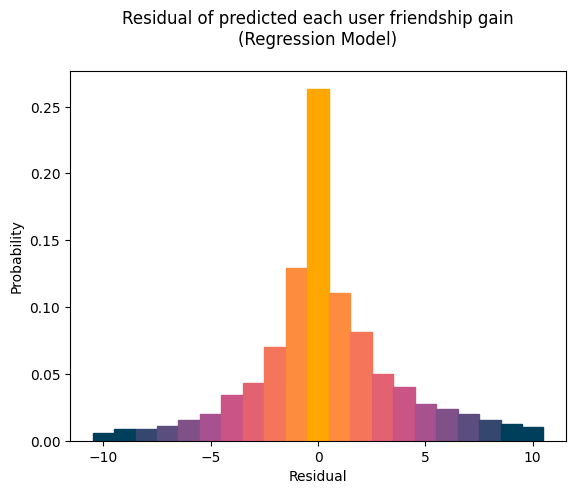

In [543]:
N, bins, patches = plt.hist(model_df.residual, bins=np.linspace(-10.5, 10.5, 22), density=True)

for i in range(len(patches)):
    patches[i].set_color(colors[i])
    
plt.title('Residual of predicted each user friendship gain\n(Regression Model)', y=1.05)
plt.xlabel("Residual")
plt.ylabel("Probability")


In [551]:
len(model_df.residual[(model_df.residual > 1) | (model_df.residual < -1)]) / len(model_df.residual)

0.6525208241999123

---